In [2]:
#Customer churn prediction project using ANN model

In [4]:
#Importing the suitable libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import shap

In [28]:
#Loading the dataset
data = pd.read_csv(r"C:\Users\mdosa\Downloads\customer.zip")
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [8]:
#Preprocessing the dataset
#Fixing the total invalid charges
data["TotalCharges"] = (
    pd.to_numeric(data["TotalCharges"], errors="coerce")
    .fillna(data["TotalCharges"].median())
)

In [9]:
#Convert churn to binary
data["Churn"] = data["Churn"].map({"Yes": 1, "No": 0})

In [10]:
#Drop ID
data.drop("customerID", axis=1, inplace=True)

In [11]:
#Label Encode categorical variables
categ_cols = data.select_dtypes(include=["object"]).columns

le = LabelEncoder()
for col in categ_cols:
    data[col] = le.fit_transform(data[col])


In [12]:
#Feature Scaling
scaler = StandardScaler()
X = data.drop("Churn", axis=1)
Y = data["Churn"]

X_scaled = scaler.fit_transform(X)


In [13]:
#Handle class imbalance(SMOTE)
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_scaled, Y)

In [14]:
#Train-Test-Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_resampled, Y_resampled, test_size=0.2, random_state=42
)

In [16]:
#Building an ANN model
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),   # <-- NEW correct way

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(16, activation='relu'),

    Dense(1, activation='sigmoid')
])

In [18]:
#Compliling and Training ANN model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model.fit(X_train, Y_train,
                    validation_split=0.2,
                    epochs=25,
                    batch_size=32,
                    verbose=1)

Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.7063 - loss: 0.5638 - val_accuracy: 0.7736 - val_loss: 0.4779
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7602 - loss: 0.4955 - val_accuracy: 0.7820 - val_loss: 0.4642
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7668 - loss: 0.4827 - val_accuracy: 0.7856 - val_loss: 0.4581
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7659 - loss: 0.4846 - val_accuracy: 0.7862 - val_loss: 0.4540
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7750 - loss: 0.4728 - val_accuracy: 0.7880 - val_loss: 0.4535
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7742 - loss: 0.4739 - val_accuracy: 0.7905 - val_loss: 0.4508
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7800 - loss: 0.4693 - val_accuracy: 0.7899 - val_loss: 0.4514
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7732 - loss: 0.4703 - val_accuracy:

In [19]:
#ANN model evaluation
Y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("ROC-AUC Score:", roc_auc_score(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Accuracy: 0.8091787439613527
ROC-AUC Score: 0.8084444959006712

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.80      1021
           1       0.78      0.86      0.82      1049

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070



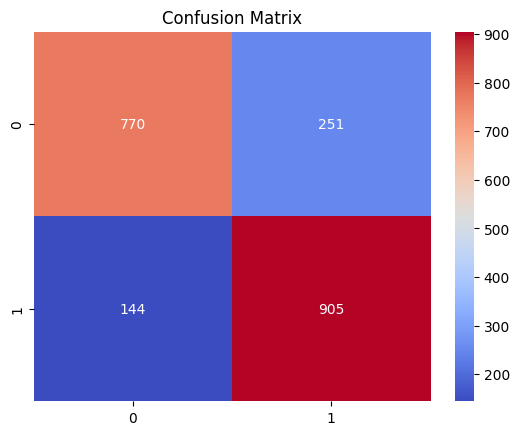

In [20]:
#Confusion matrix
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix")
plt.show()

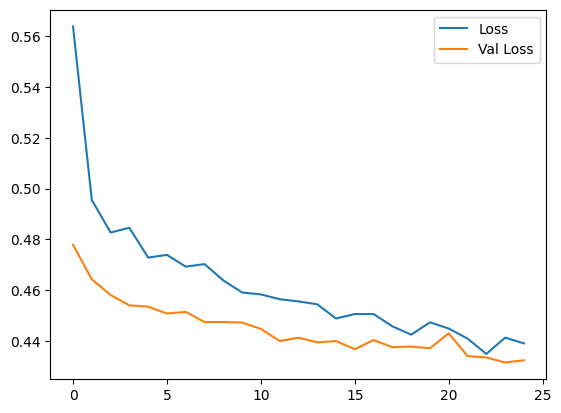

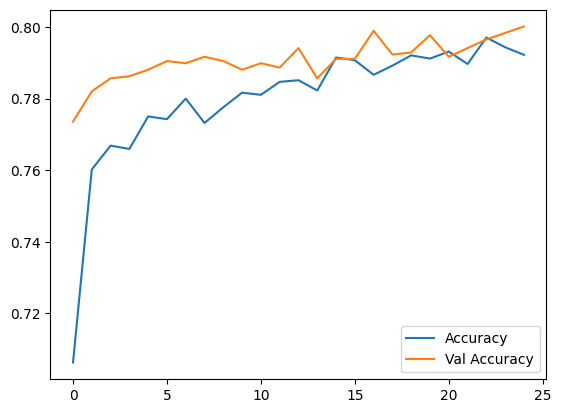

In [21]:
#Loss\Accuracy Plot
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|                                                                                                                       | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


  2%|██▏                                                                                                            | 1/50 [00:47<38:49, 47.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


  4%|████▍                                                                                                          | 2/50 [01:05<24:16, 30.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


  6%|██████▋                                                                                                        | 3/50 [01:27<20:29, 26.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


  8%|████████▉                                                                                                      | 4/50 [01:47<18:15, 23.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 10%|███████████                                                                                                    | 5/50 [02:08<17:07, 22.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 12%|█████████████▎                                                                                                 | 6/50 [02:29<16:19, 22.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 14%|███████████████▌                                                                                               | 7/50 [02:50<15:42, 21.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 16%|█████████████████▊                                                                                             | 8/50 [03:11<15:09, 21.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 18%|███████████████████▉                                                                                           | 9/50 [03:32<14:40, 21.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 20%|██████████████████████                                                                                        | 10/50 [03:53<14:14, 21.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 22%|████████████████████████▏                                                                                     | 11/50 [04:13<13:37, 20.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 24%|██████████████████████████▍                                                                                   | 12/50 [04:31<12:36, 19.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 26%|████████████████████████████▌                                                                                 | 13/50 [04:49<11:58, 19.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 28%|██████████████████████████████▊                                                                               | 14/50 [05:07<11:20, 18.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 30%|█████████████████████████████████                                                                             | 15/50 [06:21<20:43, 35.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 32%|███████████████████████████████████▏                                                                          | 16/50 [06:37<16:46, 29.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 34%|█████████████████████████████████████▍                                                                        | 17/50 [06:58<14:51, 27.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 36%|███████████████████████████████████████▌                                                                      | 18/50 [07:16<12:56, 24.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 38%|█████████████████████████████████████████▊                                                                    | 19/50 [07:37<12:02, 23.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 40%|████████████████████████████████████████████                                                                  | 20/50 [07:58<11:18, 22.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 42%|██████████████████████████████████████████████▏                                                               | 21/50 [08:17<10:23, 21.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 44%|████████████████████████████████████████████████▍                                                             | 22/50 [08:38<09:59, 21.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 46%|██████████████████████████████████████████████████▌                                                           | 23/50 [08:55<09:04, 20.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 48%|████████████████████████████████████████████████████▊                                                         | 24/50 [09:16<08:50, 20.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 50%|███████████████████████████████████████████████████████                                                       | 25/50 [09:37<08:34, 20.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 52%|█████████████████████████████████████████████████████████▏                                                    | 26/50 [09:58<08:17, 20.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 54%|███████████████████████████████████████████████████████████▍                                                  | 27/50 [10:15<07:30, 19.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 56%|█████████████████████████████████████████████████████████████▌                                                | 28/50 [10:36<07:21, 20.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 58%|███████████████████████████████████████████████████████████████▊                                              | 29/50 [10:58<07:09, 20.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 60%|██████████████████████████████████████████████████████████████████                                            | 30/50 [11:19<06:52, 20.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 62%|████████████████████████████████████████████████████████████████████▏                                         | 31/50 [11:40<06:34, 20.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 64%|██████████████████████████████████████████████████████████████████████▍                                       | 32/50 [12:01<06:14, 20.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 66%|████████████████████████████████████████████████████████████████████████▌                                     | 33/50 [12:17<05:32, 19.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 68%|██████████████████████████████████████████████████████████████████████████▊                                   | 34/50 [12:39<05:21, 20.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████████████                                 | 35/50 [12:56<04:48, 19.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 72%|███████████████████████████████████████████████████████████████████████████████▏                              | 36/50 [13:17<04:36, 19.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████▍                            | 37/50 [13:38<04:22, 20.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████▌                          | 38/50 [13:59<04:05, 20.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████▊                        | 39/50 [14:20<03:47, 20.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 40/50 [14:37<03:15, 19.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████▏                   | 41/50 [14:56<02:54, 19.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████▍                 | 42/50 [15:17<02:39, 19.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▌               | 43/50 [15:38<02:21, 20.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▊             | 44/50 [15:59<02:02, 20.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 45/50 [16:17<01:38, 19.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/50 [16:38<01:20, 20.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 47/50 [16:59<01:01, 20.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 48/50 [17:17<00:39, 19.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 49/50 [17:38<00:20, 20.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [18:00<00:00, 21.60s/it]


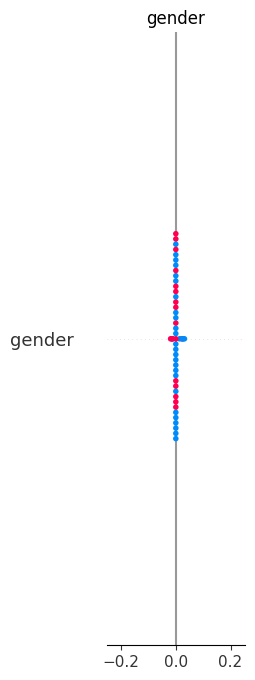

In [22]:
#Explainable AI(SHAP)
explainer = shap.KernelExplainer(model.predict, X_train[:100])
shap_values = explainer.shap_values(X_test[:50])

shap.summary_plot(shap_values, X_test[:50], feature_names=X.columns)

In [23]:
#Prediction function
def predict(data):
    data_scaled = scaler.transform([data])
    pred = model.predict(data_scaled)[0][0]
    return "Churn" if pred > 0.5 else "Not Churn"

In [26]:
sample1= [
    1,   # Gender(Male)
    0,   # Senior Citizen
    0,   # Partner
    1,   # Dependents
    1,   # Tenure
    1,   # PhoneService
    0,   # MultipleLines
    2,   # InternetService(2 = Fiber optic)
    0,   # OnlineSecurity
    0,   # OnlineBackup
    0,   # DeviceProtection
    0,   # TechSupport
    1,   # StreamingTV
    1,   # StreamingMovies
    0,   # Contract (0 = Month-to-month)
    1,   # PaperlessBilling (Yes)
    3,   # PaymentMethod (3 = Electronic check)
    95.5, # MonthlyCharges
    95.5  # TotalCharges
]
print(predict(sample1))

C:\Users\mdosa\anaconda3\envs\projects\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Churn


In [27]:
sample2 = [
    0,   # Gender(Female)
    0,   # Senior Citizen
    1,   # Partner
    1,   # Dependents
    45,  # tenure
    1,   # PhoneService
    1,   # MultipleLines
    0,   # InternetService(0 = DSL)
    1,   # OnlineSecurity
    1,   # OnlineBackup
    1,   # DeviceProtection
    1,   # TechSupport
    0,   # StreamingTV
    0,   # StreamingMovies
    2,   # Contract (2 = Two year)
    0,   # PaperlessBilling
    1,   # PaymentMethod (1 = Credit card auto)
    55.3, # MonthlyCharges
    2490.0 # TotalCharges
]
print(predict(sample2))

C:\Users\mdosa\anaconda3\envs\projects\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Not Churn
